# Abstract

This notebook serves as foundation for further experiments of application MARS to autoencoder and variational autoencoder models. It is slightly modified so that only the main information is left.

Source: https://avandekleut.github.io/vae/

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Autoencoder


Below we write the `Encoder` class by sublcassing `torch.nn.Module`, which lets us define the `__init__` method storing layers as an attribute, and a `forward` method describing the forward pass of the network.

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

We do something similar for the `Decoder` class, ensuring we reshape the output.

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

FInally, we write an `Autoencoder` class that combines these two. Note that we could have easily written this entire autoencoder as a single neural network, but splitting them in two makes it conceptually clearer.

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## Training

Next, we will write some code to train the autoencoder on the MNIST dataset.

In [6]:
def train(autoencoder, data, epochs=100):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [7]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)

100%|█████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


## Plots

In [8]:
def plot_latent(autoencoder, data, num_batches=100, path=None):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            if path:
                plt.savefig(path)
            break

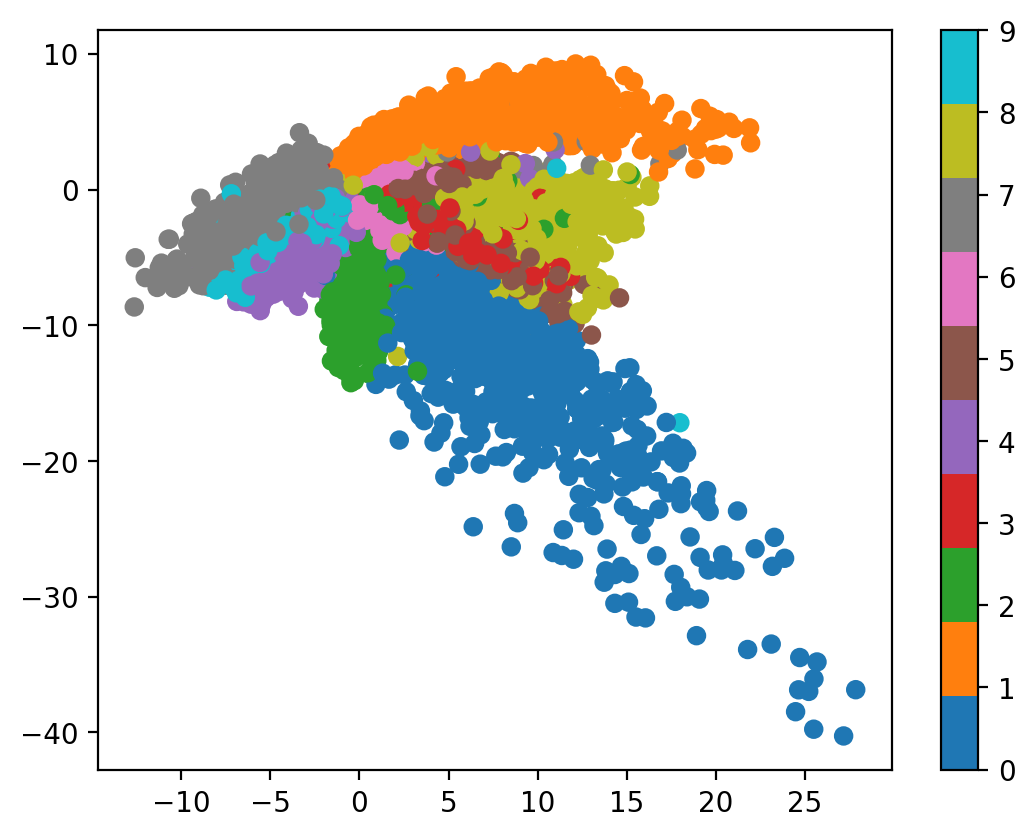

In [9]:
plot_latent(autoencoder, data, path="images/AE-Base-latent")

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

In [10]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12, path=None):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    if path:
        plt.savefig(path)

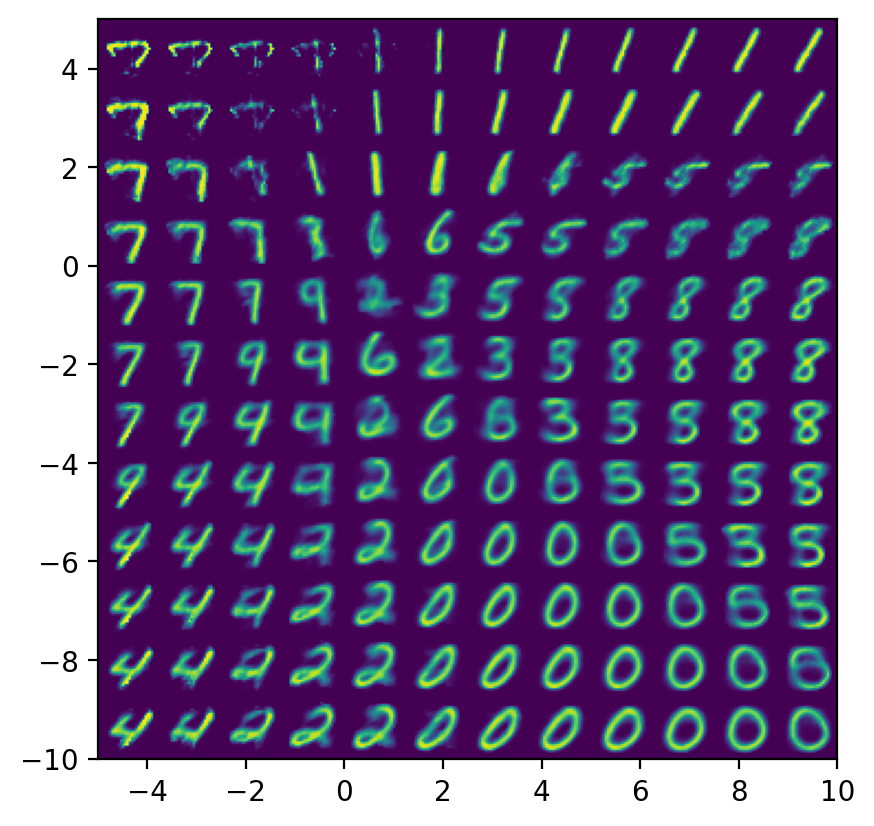

In [11]:
plot_reconstructed(autoencoder, path = "images/AE-Base-reconstructed")

# Variational Autoencoder

In [12]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

The autoencoder class changes a single line of code, swappig out an `Encoder` for a `VariationalEncoder`. 

In [13]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In order to train the variational autoencoder, we only need to add the auxillary loss in our training algorithm.

The following code is essentially copy-and-pasted from above, with a single term added added to the loss (`autoencoder.encoder.kl`).

## Training

In [14]:
def train(autoencoder, data, epochs=100):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [15]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)

100%|█████████████████████████████████████████| 100/100 [06:11<00:00,  3.71s/it]


## Plots

Let's plot the latent vector representations of a few batches of data.

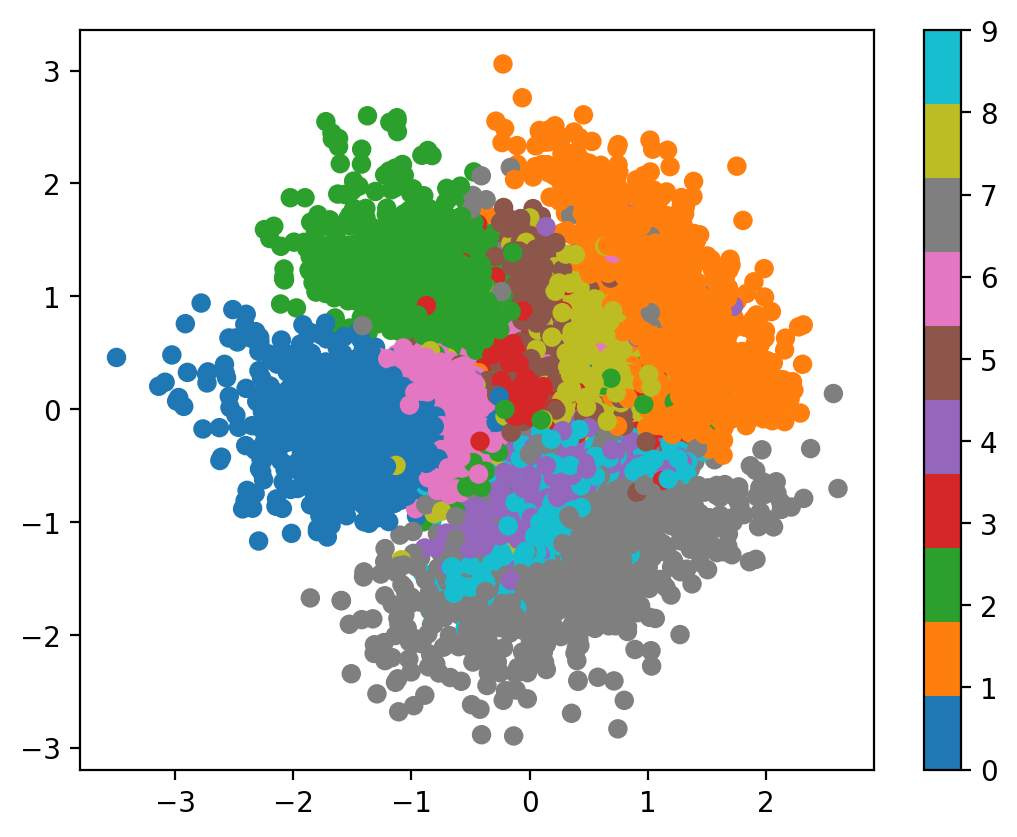

In [16]:
plot_latent(vae, data, path="images/VAE-Base-latent")

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

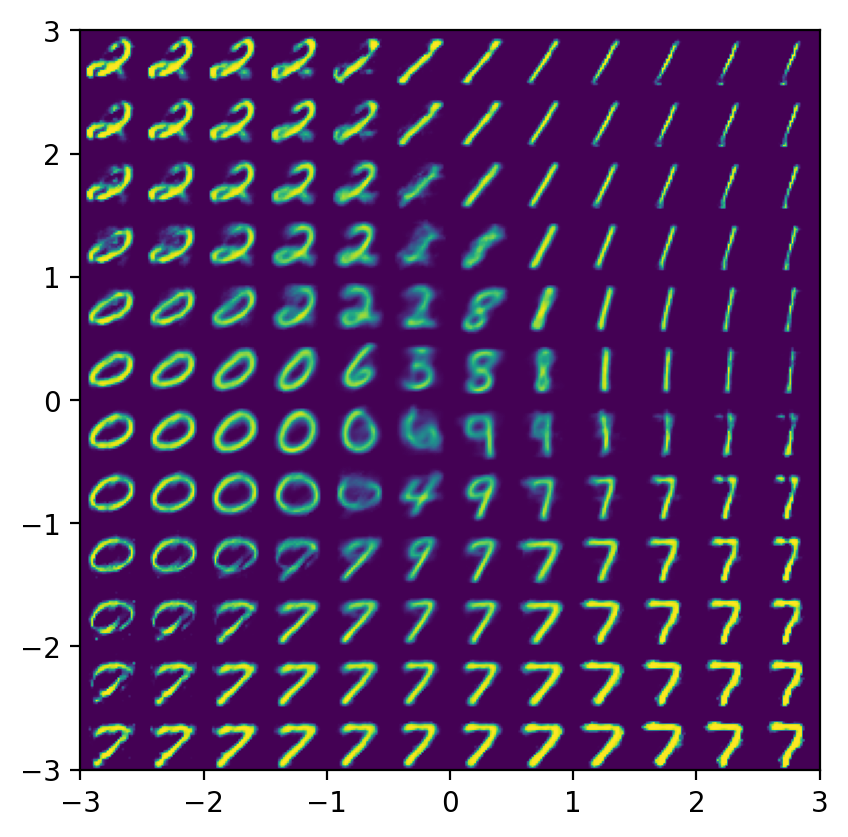

In [17]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3), path="images/VAE-Base-reconstructed")

### Interpolation

The following code produces a row of images showing the interpolation between digits.

In [18]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [19]:
x, y = next(iter(data)) # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

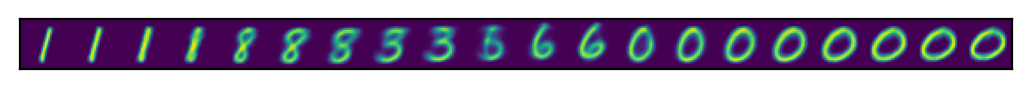

In [20]:
interpolate(vae, x_1, x_2, n=20)

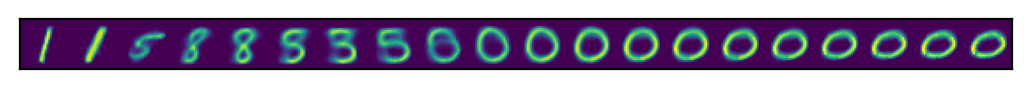

In [21]:
interpolate(autoencoder, x_1, x_2, n=20)

In [22]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning
    
    images_list[0].save(
        f'{filename}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=1)

In [23]:
interpolate_gif(vae, "images/vae", x_1, x_2)

<img src='vae.gif'>

## Time

Now check the time inference takes.

In [29]:
batch = next(iter(data))[0]

In [37]:
%timeit vae(batch)

756 µs ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
%%timeit
y = autoencoder(batch)

684 µs ± 3.76 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
